# Working with GRACE to build a mask and calculate water balance

by Anthony Arendt and Landung Setiawan

Datasets:
- GRACE: https://ssed.gsfc.nasa.gov/grace/products.html
- LIS: https://github.com/NASA-Planetary-Science/HiMAT/tree/master/Projects/LIS

In [1]:
# Import the necessary libraries
%matplotlib inline
import os
import glob
import sys
import datetime
import pickle
from datetime import timedelta

import xarray as xr

import pandas as pd
import numpy as np

import geopandas as gpd

from dask.diagnostics import ProgressBar

import seaborn as sb

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import regionmask

from shapely.geometry import Polygon

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from himatpy.LIS import utils
from himatpy.tools import animation_tools
from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis)

In [2]:
datadir = os.path.abspath('../data/')

## Get Grace Data

In [3]:
# Read in mascon file
grace_file = os.path.join(datadir, 'GSFC.glb.200301_201607_v02.3b-ICE6G.h5')
try:
    f = extract_grace(grace_file)
except FileNotFoundError as e:
    print(e)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [4]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

In [5]:
# Get mascon gdf
mascon_gdf = get_mascon_gdf(mascon)

# we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


In [6]:
# Filter only mascon within HMA geographical areas
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]

## Retrieve LIS Dataset

In [17]:
lis_dir = glob.glob(os.path.join(datadir, '*Monthly.nc'))[:-1]
lis_ds = xr.open_mfdataset(lis_dir, chunks={'time': 10})
# getting the max/min lat/lon from the LIS dataset
minLong = lis_ds.coords['longitude'].min().values
maxLong = lis_ds.coords['longitude'].max().values
minLat = lis_ds.coords['latitude'].min().values
maxLat = lis_ds.coords['latitude'].max().values
bbox = [minLong, minLat, maxLong, maxLat]

## Build Mask

In [18]:
m = build_mask(bbox, HMA, dacoords=lis_ds.coords, serialize=True, datadir=datadir)

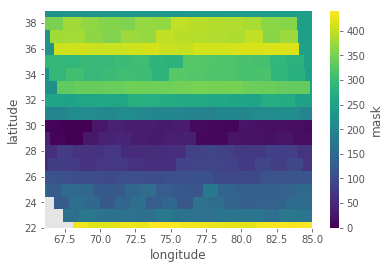

In [19]:
m.plot(x='longitude', y='latitude')

## Apply Mask

In [20]:
ds_masked = lis_ds.groupby(m).sum('stacked_north_south_east_west')

In [21]:
ds_masked

<xarray.Dataset>
Dimensions:     (mask: 304, time: 180)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 2001-03-01 ...
  * mask        (mask) float64 0.0 1.0 3.0 4.0 5.0 6.0 7.0 9.0 10.0 12.0 ...
Data variables:
    Qs_tavg     (mask, time) float64 dask.array<shape=(304, 180), chunksize=(1, 10)>
    Rainf_tavg  (mask, time) float64 dask.array<shape=(304, 180), chunksize=(1, 10)>
    Qsb_tavg    (mask, time) float64 dask.array<shape=(304, 180), chunksize=(1, 10)>
    Snowf_tavg  (mask, time) float64 dask.array<shape=(304, 180), chunksize=(1, 10)>